In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.tree import DecisionTreeClassifier,export_graphviz,export_text
from sklearn.metrics import r2_score,accuracy_score,roc_auc_score,f1_score,recall_score,\
                             classification_report,confusion_matrix,roc_curve

from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,validation_curve

from skompiler import skompile

In [3]:
from warnings import filterwarnings
filterwarnings("ignore")

In [4]:
import pickle

In [5]:
pd.set_option("display.max_columns",None)
pd.set_option("display.float_format" , lambda x : "%.4f" % x) 
pd.set_option("display.width", 200)

**Feature engineered before diabetes.**

**If you want, you can check out the diabetes feature engineering and the Model on the github repository.**

**https://github.com/syngokhan/Diabetes_Model-Feature_Engineering-**

In [6]:
################################################
# Modeling Using Cart
################################################

In [7]:
df = pickle.load(open("diabetes.pkl", "rb"))

In [8]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NEW_INSULIN_1,NEW_AGE_CAT_1,NEW_BMI_AGE_1,NEW_BMI_AGE_2,NEW_BMI_AGE_3,NEW_BMI_AGE_4,NEW_BMI_AGE_5,NEW_BMI_AGE_6,NEW_AGE_GLUCOSE_1,NEW_AGE_GLUCOSE_2,NEW_AGE_GLUCOSE_3,NEW_BMI_1,NEW_BMI_2,NEW_BMI_3,NEW_GLUCOSE_1
0,0.6471,0.8646,-0.0308,0.8143,0.6269,0.1840,0.5889,1.4457,1,0,1,0,0,1,0,0,0,0,0,1,1,0,0,1
1,-0.8490,-1.2047,-0.5437,0.0201,-0.5266,-0.8657,-0.3781,-0.1893,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
2,1.2456,2.0143,-0.7146,0.4172,0.6269,-1.3606,0.7466,-0.1033,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
3,-0.8490,-1.0733,-0.5437,-0.7742,-0.6729,-0.6407,-1.0228,-1.0498,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,-1.1482,0.5033,-2.7661,0.8143,0.6011,1.6087,2.5966,-0.0172,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0


In [9]:
X = df.drop("Outcome", axis = 1)
y = df["Outcome"]

In [10]:
cart_model = DecisionTreeClassifier(random_state=17).fit(X,y)

y_pred = cart_model.predict(X)
y_proba = cart_model.predict_proba(X)[:,1]

In [11]:
def roc_auc_graph(model , X, y):
    
    y_proba = model.predict_proba(X)[:,1]
    roc_score = roc_auc_score(y , y_proba)
    size = 15
    
    fpr,tpr,thresholds = roc_curve(y, y_proba)
    plt.figure(figsize = (7,5))
    
    plt.plot(fpr, tpr )
    plt.plot([0,1],[0,1],"--r")
    
    plt.title(f" ROC_AUC ( Area : {round(roc_score,4)})" , fontsize = size)
    plt.xlabel("False Positive Rate",fontsize = size)
    plt.ylabel("True Positive Rate", fontsize = size)
    plt.show()
    
def confusion_matrix_graph(model , X , y):
    
    size = 15
    
    y_pred = model.predict(X)
    
    cm = confusion_matrix(y,y_pred)
    
    fig , axes = plt.subplots(figsize = (7,5))
    
    axes = sns.heatmap(data = cm , annot= True , annot_kws={"size":25}, linecolor="white",linewidths=3,
                       fmt=".3g", cbar=False , cmap = "viridis")
    
    plt.xlabel("Predict Label", fontsize = size)
    plt.ylabel("True Label", fontsize = size)
    plt.title(f"For {type(model).__name__.upper()} Confusion Matrix", fontsize = size)

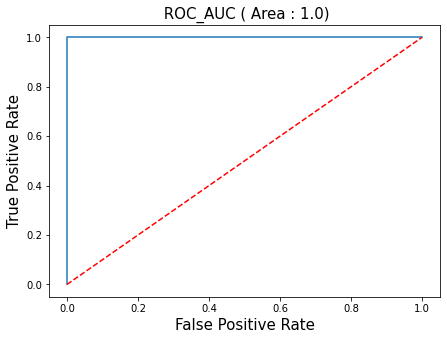

In [12]:
#It is clear that this result is not correct and the model overfits.
roc_auc_graph(cart_model, X ,y)

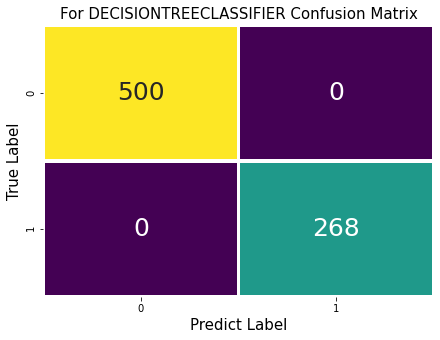

In [13]:
#It is clear that this result is not correct and the model overfits.
confusion_matrix_graph(cart_model,X,y)

In [14]:
#####################
# Success Evaluation (Validation) with Holdout Method
#####################

In [15]:
def holdout_method(model,X,y,train = False ,test = False):
    
    X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = .2, random_state = 99)
    
    model.fit(X_train , y_train)
    
    if train:
        
        print(" For Train Error ".upper().center(50,"#"))
        
        roc_auc_graph(model,X_train , y_train)
    
        confusion_matrix_graph(model, X_train, y_train)
        
    
    if test:
        
        print(" For Test Error ".upper().center(50,"#"))
        
        roc_auc_graph(model,X_test , y_test)
    
        confusion_matrix_graph(model, X_test, y_test)

################ FOR TRAIN ERROR #################


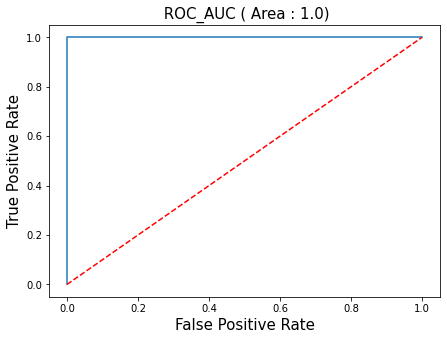

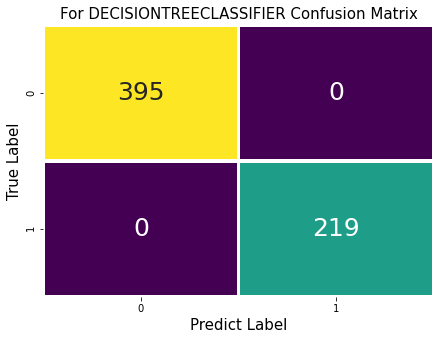

In [16]:
holdout_method(DecisionTreeClassifier(random_state=17), X, y, train = True, test = False)

################# FOR TEST ERROR #################


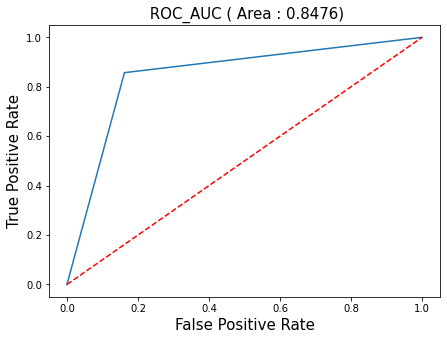

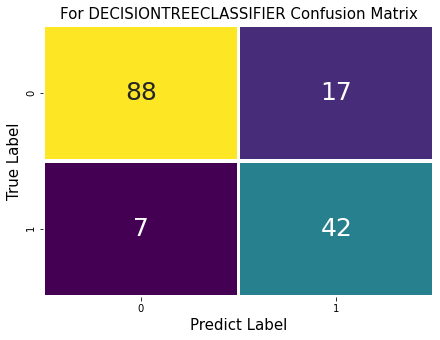

In [17]:
holdout_method(DecisionTreeClassifier(random_state=17), X, y, train = False, test = True)

In [18]:
#####################
# Success Evaluation with CV
#####################

In [19]:
def base_cv_model(model, X, y):
    
    #model = DecisionTreeClassifier(random_state=17).fit(X,y)
    data = pd.DataFrame()
    index = 0
    
    cv_results = cross_validate(estimator=model,
                                X = X,
                                y = y,
                                cv = 10,
                                scoring = ["accuracy","f1","roc_auc"])
    
    cv_accuracy = cv_results["test_accuracy"].mean()
    cv_roc_auc = cv_results["test_roc_auc"].mean()
    cv_f1 = cv_results["test_f1"].mean()
    
    data.loc[index, "NAME"] = type(model).__name__.upper()
    data.loc[index, "ROC_AUC"] = cv_roc_auc
    data.loc[index, "ACCURACY"] = cv_accuracy
    data.loc[index, "F1_SCORE"] = cv_f1
    data.loc[index, "FIT_TIME"] = cv_results["fit_time"].mean()
    data.loc[index, "SCORE_TIME"] = cv_results["score_time"].mean()
    data = data.set_index("NAME")
    
    return data

In [20]:
base_cv_model(DecisionTreeClassifier(random_state=17) , X , y)

,ROC_AUC,ACCURACY,F1_SCORE,FIT_TIME,SCORE_TIME
NAME,,,,,
DECISIONTREECLASSIFIER,0.8317,0.8450,0.7793,0.0035,0.0031


In [21]:
################################################
# 4. Hyperparameter Optimization with GridSearchCV
################################################

In [22]:
cart_params = {'max_depth': [2, 5, 6, 8, 10, None],
               "min_samples_split": [2, 4, 5, 6, 8, 10]}

In [23]:
def hyperparameter_optimization(model , X , y , params, cv = 10) :
    
    best_grid = GridSearchCV(estimator= model,
                             param_grid= params,
                             cv = cv,
                             n_jobs=-1,
                             verbose=0).fit(X,y)
    
    best_params = best_grid.best_params_
    
    return best_params

In [24]:
best_params = hyperparameter_optimization(DecisionTreeClassifier(random_state=17), X, y, cart_params, cv = 10)
best_params

{'max_depth': 5, 'min_samples_split': 2}

In [25]:
################################################
# 5. Final Model
################################################

In [26]:
def final_model(model, X, y, best_params):
    
    final_model_ = model.set_params(**best_params).fit(X,y)
    
    data = pd.DataFrame()
    index = 0
    
    final_cv_results = cross_validate(estimator=final_model_,
                                    X = X,
                                    y = y,
                                    cv = 10,
                                    scoring = ["accuracy","f1","roc_auc"])
    
    cv_accuracy = final_cv_results["test_accuracy"].mean()
    cv_roc_auc = final_cv_results["test_roc_auc"].mean()
    cv_f1 = final_cv_results["test_f1"].mean()
    
    data.loc[index, "NAME"] = type(model).__name__.upper()
    data.loc[index, "ROC_AUC"] = cv_roc_auc
    data.loc[index, "ACCURACY"] = cv_accuracy
    data.loc[index, "F1_SCORE"] = cv_f1
    data.loc[index, "FIT_TIME"] = final_cv_results["fit_time"].mean()
    data.loc[index, "SCORE_TIME"] = final_cv_results["score_time"].mean()
    data = data.set_index("NAME")
    
    return final_model_,data

In [27]:
final_model,data = final_model(DecisionTreeClassifier(random_state=17), X, y, best_params)

In [28]:
final_model.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'presort': 'deprecated',
 'random_state': 17,
 'splitter': 'best'}

In [29]:
data

,ROC_AUC,ACCURACY,F1_SCORE,FIT_TIME,SCORE_TIME
NAME,,,,,
DECISIONTREECLASSIFIER,0.9049,0.8738,0.8078,0.0029,0.0030


In [30]:
################################################
# 6. Feature Importance
################################################

In [31]:
def plot_importance(model , features, num = 10, save = False):
    
    feature_imp = pd.DataFrame({"Value": model.feature_importances_,
                                "Feature" : features.columns})
    
    plt.figure(figsize = (10,10))
    sns.set(font_scale = 1)
    sns.barplot(x = "Value" , y= "Feature" , data = feature_imp.sort_values(by = "Value", \
                                                                            ascending = False)[0:num])
    
    size = 15
    plt.title("Features", fontsize = size)
    plt.tight_layout()
    plt.show()
    
    if save :
        plt.savefig("importances.png")

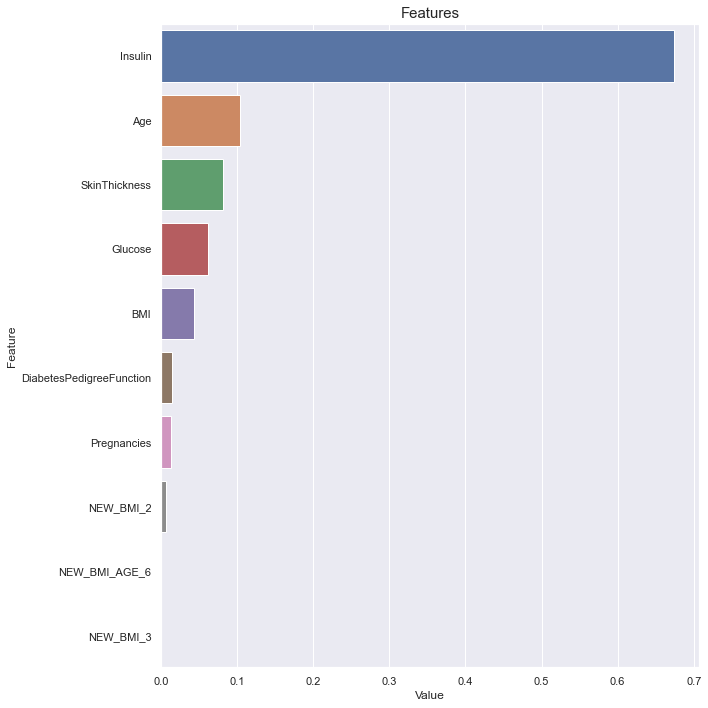

In [32]:
plot_importance(final_model, X)

In [33]:
################################################
# 7. Analyzing Model Complexity with Learning Curves (BONUS)
################################################

In [34]:
best_params

{'max_depth': 5, 'min_samples_split': 2}

In [35]:
cart_params

{'max_depth': [2, 5, 6, 8, 10, None], 'min_samples_split': [2, 4, 5, 6, 8, 10]}

In [36]:
def val_curve_params(model, X, y , param_name, param_range ,scoring = "roc_name", cv = 10):
    
    train_score, test_score = validation_curve(estimator = model,
                                               param_name = param_name,
                                               param_range =  param_range,
                                               X = X , 
                                               y = y , 
                                               cv = cv,
                                               n_jobs=-1,
                                               verbose=0)
    
    mean_train_score = np.mean(train_score, axis = 1)
    mean_test_score = np.mean(test_score, axis = 1)
    
    plt.plot(param_range, mean_train_score, label = " Training Score", color = "b")
    
    plt.plot(param_range, mean_test_score , label = " Validation Score" , color = "g")
    
    plt.title(f"Validation Curve for {type(model).__name__.upper()}")
    plt.xlabel(f"Number of {param_name}")
    plt.ylabel(f"{scoring}")
    plt.tight_layout()
    plt.legend(loc = "best")
    plt.show()

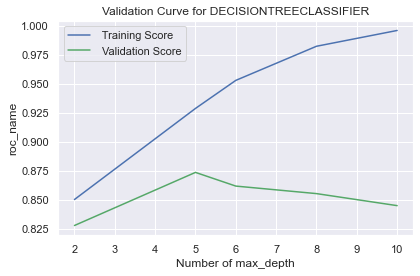

In [37]:
val_curve_params(DecisionTreeClassifier(random_state=17), X , y, param_name="max_depth", 
                 param_range=cart_params["max_depth"])

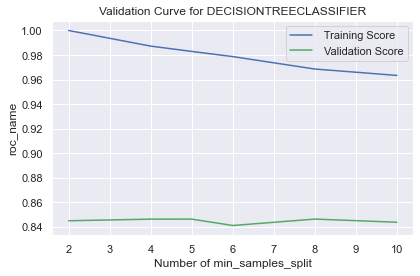

In [38]:
val_curve_params(DecisionTreeClassifier(random_state=17), X , y, param_name="min_samples_split", 
                 param_range=cart_params["min_samples_split"])

In [39]:
################################################
# 8. Visualizing the Decision Tree
################################################

In [40]:
import pydotplus

def tree_graph_to_png(tree, feature_names, png_file_to_save):
    
    tree_str = export_graphviz(tree, feature_names= feature_names, filled=True, out_file = None)
    graph = pydotplus.graph_from_dot_data(tree_str)
    graph.write_png(png_file_to_save)

In [41]:
tree_graph_to_png(tree = final_model, feature_names=X.columns, png_file_to_save= "cart.png")

In [42]:
################################################
# 9. Extracting Decision Rules
################################################

In [43]:
tree_rules = export_text(final_model, feature_names=list(X.columns))
print(tree_rules)

|--- Insulin <= -0.21
|   |--- BMI <= 2.42
|   |   |--- Pregnancies <= 2.82
|   |   |   |--- Insulin <= -0.41
|   |   |   |   |--- Insulin <= -0.58
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Insulin >  -0.58
|   |   |   |   |   |--- class: 0
|   |   |   |--- Insulin >  -0.41
|   |   |   |   |--- SkinThickness <= 0.88
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- SkinThickness >  0.88
|   |   |   |   |   |--- class: 1
|   |   |--- Pregnancies >  2.82
|   |   |   |--- class: 1
|   |--- BMI >  2.42
|   |   |--- class: 1
|--- Insulin >  -0.21
|   |--- Age <= -0.40
|   |   |--- SkinThickness <= 0.35
|   |   |   |--- Glucose <= 1.51
|   |   |   |   |--- BMI <= 0.91
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- BMI >  0.91
|   |   |   |   |   |--- class: 1
|   |   |   |--- Glucose >  1.51
|   |   |   |   |--- NEW_BMI_2 <= 0.50
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- NEW_BMI_2 >  0.50
|   |   |   |   |   |--- class: 0
|   |   |--- SkinThickness >  0

In [44]:
################################################
# 10. Extracting Python Codes of Decision Rules
################################################

In [45]:
print(skompile(final_model.predict).to("python/code"))

(((((0 if x[4] <= -0.57820725440979 else 0) if x[4] <= -0.4146575778722763 else
    0 if x[3] <= 0.8805246651172638 else 1) if x[0] <= 2.8165230751037598 else
    1) if x[5] <= 2.4221946001052856 else 1) if x[4] <= 
    -0.20806852728128433 else (((0 if x[5] <= 0.911342203617096 else 1) if 
    x[1] <= 1.5051383972167969 else 1 if x[20] <= 0.5 else 0) if x[3] <= 
    0.35102055966854095 else (0 if x[1] <= -0.9747986495494843 else 1) if x
    [3] <= 0.48339660465717316 else 0 if x[1] <= 1.521561861038208 else 1) if
    x[7] <= -0.4044349193572998 else ((0 if x[7] <= 0.5421411097049713 else
    1) if x[4] <= 0.15346231311559677 else 1 if x[3] <= -1.7008078694343567
     else 1) if x[4] <= 0.7301900684833527 else (0 if x[5] <= 
    1.2337573766708374 else 1) if x[1] <= 1.1766698956489563 else 1 if x[6] <=
    2.233927369117737 else 0)



In [46]:
print(skompile(final_model.predict).to("sqlalchemy/sqlite"))

SELECT CASE WHEN (x5 <= -0.20806852728128433) THEN CASE WHEN (x6 <= 2.4221946001052856) THEN CASE WHEN (x1 <= 2.8165230751037598) THEN CASE WHEN (x5 <= -0.4146575778722763) THEN 0 ELSE CASE WHEN (x4 <= 0.8805246651172638) THEN 0 ELSE 1 END END ELSE 1 END ELSE 1 END ELSE CASE WHEN (x8 <= -0.4044349193572998) THEN CASE WHEN (x4 <= 0.35102055966854095) THEN CASE WHEN (x2 <= 1.5051383972167969) THEN CASE WHEN (x6 <= 0.911342203617096) THEN 0 ELSE 1 END ELSE CASE WHEN (x21 <= 0.5) THEN 1 ELSE 0 END END ELSE CASE WHEN (x4 <= 0.48339660465717316) THEN CASE WHEN (x2 <= -0.9747986495494843) THEN 0 ELSE 1 END ELSE CASE WHEN (x2 <= 1.521561861038208) THEN 0 ELSE 1 END END END ELSE CASE WHEN (x5 <= 0.7301900684833527) THEN CASE WHEN (x5 <= 0.15346231311559677) THEN CASE WHEN (x8 <= 0.5421411097049713) THEN 0 ELSE 1 END ELSE 1 END ELSE CASE WHEN (x2 <= 1.1766698956489563) THEN CASE WHEN (x6 <= 1.2337573766708374) THEN 0 ELSE 1 END ELSE CASE WHEN (x7 <= 2.233927369117737) THEN 1 ELSE 0 END END END E

In [47]:
from warnings import filterwarnings
filterwarnings("ignore")

print(skompile(final_model.predict).to("excel"))

A1=IF((x5<=-0.208068527 ...541 chars skipped... 7369117737),1,0)))))


In [48]:
################################################
# 11. Prediction using Python Codes
################################################

In [49]:
def predict_with_rules(x):
    
    return (((((0 if x[4] <= -0.57820725440979 else 0) if x[4] <= -0.4146575778722763 else
    0 if x[3] <= 0.8805246651172638 else 1) if x[0] <= 2.8165230751037598 else
    1) if x[5] <= 2.4221946001052856 else 1) if x[4] <= 
    -0.20806852728128433 else (((0 if x[5] <= 0.911342203617096 else 1) if 
    x[1] <= 1.5051383972167969 else 1 if x[20] <= 0.5 else 0) if x[3] <= 
    0.35102055966854095 else (0 if x[1] <= -0.9747986495494843 else 1) if x
    [3] <= 0.48339660465717316 else 0 if x[1] <= 1.521561861038208 else 1) if
    x[7] <= -0.4044349193572998 else ((0 if x[7] <= 0.5421411097049713 else
    1) if x[4] <= 0.15346231311559677 else 1 if x[3] <= -1.7008078694343567
     else 1) if x[4] <= 0.7301900684833527 else (0 if x[5] <= 
    1.2337573766708374 else 1) if x[1] <= 1.1766698956489563 else 1 if x[6] <=
    2.233927369117737 else 0)

In [50]:
len(X.columns)

23

In [51]:
x = np.linspace(1,100,23)
predict_with_rules(x)

0

In [52]:
################################################
# 12. Saving and Loading Model
################################################

In [53]:
import joblib

In [54]:
joblib.dump(final_model, "cart_final.pkl")

cart_model_from_disk = joblib.load("cart_final.pkl")

cart_model_from_disk.predict(pd.DataFrame(x).T)

array([0])